## Visualize performance
Looking at performance of DistilBert on task with 10 anchor posts, 1 negative and 1 positive example. <br>
**NEXT UP: embedding visualizer; attention**

In [103]:
import gzip
from reddit.utils import load_tfrecord
import json
import numpy as np
from pathlib import Path
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
import random
from IPython.display import Markdown, display

Load model performance metrics

In [104]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [105]:
METRICS_PATH = Path('../logs/10anchor_1pos_1neg_random/metrics/') 
METRICS_PATH = METRICS_PATH / 'BatchTransformer-distilbert-base-uncased'
METRICS_PATH = METRICS_PATH / 'triplet_loss_margin-1.0'
d = {}
for i in range(3):
    d[f'epoch-{str(i)}'] = json.load(open(METRICS_PATH / f'epoch-{str(i)}' / 'log.json'))
d['baseline'] = json.load(open(METRICS_PATH / f'epoch-baseline' / 'log.json'))

Load baselines

In [106]:
BASELINE_PATH = Path('../logs/baselines_10anchor_1pos_1neg_ds1/metrics/') 
DB_BASELINE_PATH = BASELINE_PATH / 'BatchTransformer-distilbert-base-uncased'
DB_BASELINE_PATH = DB_BASELINE_PATH / 'triplet_loss_margin-1'
d['distilbert-baseline'] = json.load(open(DB_BASELINE_PATH / f'epoch-test_only' / 'log.json'))
# Bert baseline
B_BASELINE_PATH = BASELINE_PATH / 'BatchTransformer-bert-base-uncased'
B_BASELINE_PATH = B_BASELINE_PATH / 'triplet_loss_margin-1'
d['bert-baseline'] = json.load(open(B_BASELINE_PATH / f'epoch-test_only' / 'log.json'))

Baseline performance

In [107]:
print('Distilbert uncased baseline performance:')
print(np.mean(d['distilbert-baseline']['test_metrics']))
print('Bert uncased baseline performance:')
print(np.mean(d['bert-baseline']['test_metrics']))

Distilbert uncased baseline performance:
0.735331709552174
Bert uncased baseline performance:
0.7073476097459024


In [108]:
for i in range(3):
    trp = np.mean(d[f'epoch-{str(i)}']['metrics'])
    tsp = np.mean(d[f'epoch-{str(i)}']['test_metrics'])
    print(f'Epoch {i}: Train - {trp}, Test: {tsp}')

Epoch 0: Train - 0.908910813227889, Test: 0.9254275005856173
Epoch 1: Train - 0.947881032992756, Test: 0.9379421410166315
Epoch 2: Train - 0.9792441038949304, Test: 0.9434176622159757


### Visualize performance

Percentage correct over epochs (grey line is test performance)

In [109]:
n_ex = 1195320
avg_by = 1000
mtrs_idx = list(np.arange(0, n_ex, avg_by))

In [110]:
def _roll_avg(lst):
    return [np.mean(lst[mtrs_idx[i]:mtrs_idx[i+1]]) for i in range(len(mtrs_idx)-1)]

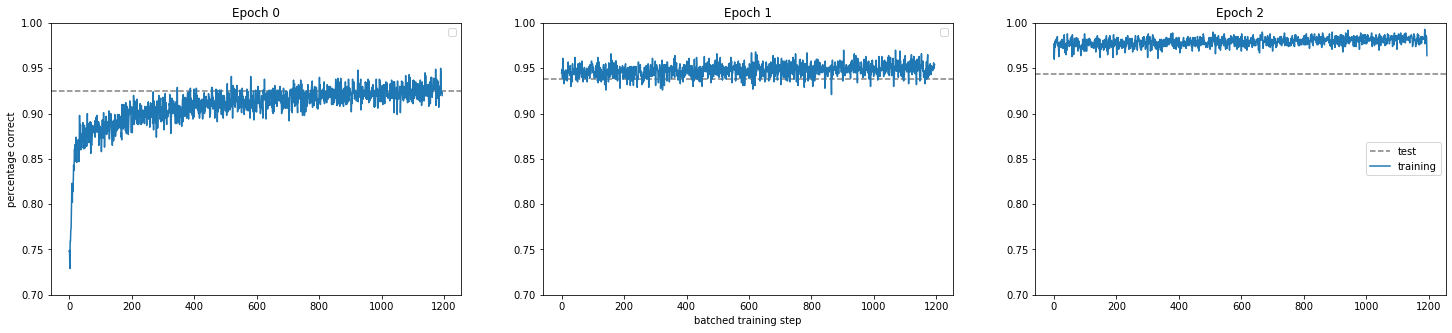

In [111]:
f, ax = plt.subplots(ncols=3, figsize=(25,5))
for i in range(3):
    mtrs = _roll_avg(d[f'epoch-{str(i)}']['metrics'])
    mean_test = np.mean(d[f'epoch-{str(i)}']['test_metrics'])
    ax[i].set_ylim(.7,1)
    ax[i].axhline(mean_test, ls='--', 
                  color='grey', 
                  label='test')
    ax[i].set_title(f'Epoch {i}')
    if i == 1:
        ax[i].set_xlabel('batched training step')
    if i == 0:
        ax[i].set_ylabel('percentage correct')
    sns.lineplot(x=range(len(mtrs)), 
                 y=mtrs, 
                 ax=ax[i], 
                 label='training')
    if i != 2:
        ax[i].legend('')
    else:
        ax[i].legend(loc='center right')
plt.show()

Visualize loss

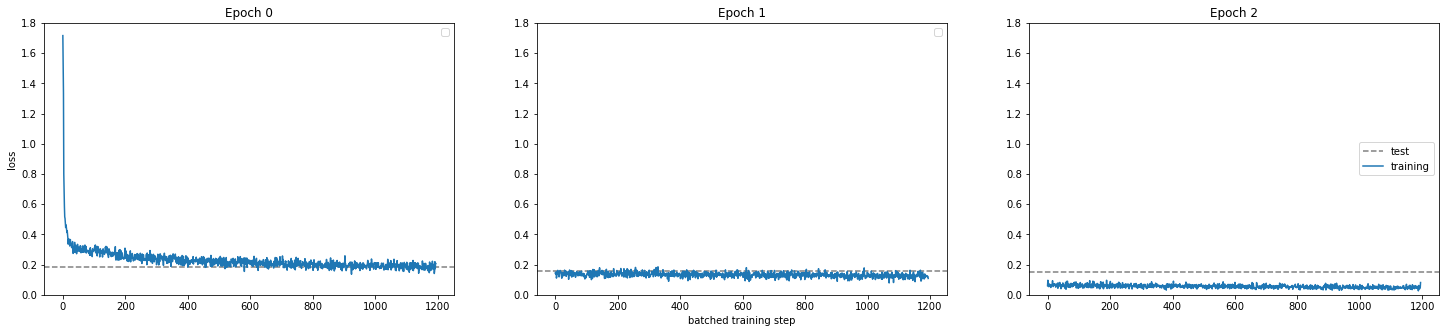

In [112]:
f, ax = plt.subplots(ncols=3, figsize=(25,5))
for i in range(3):
    mtrs = _roll_avg(d[f'epoch-{str(i)}']['losses'])
    mean_test = np.mean(d[f'epoch-{str(i)}']['test_losses'])
    ax[i].set_ylim(.0,1.8)
    ax[i].axhline(mean_test, ls='--', 
                  color='grey', 
                  label='test')
    ax[i].set_title(f'Epoch {i}')
    if i == 1:
        ax[i].set_xlabel('batched training step')
    if i == 0:
        ax[i].set_ylabel('loss')
    sns.lineplot(x=range(len(mtrs)), 
                 y=mtrs, 
                 ax=ax[i], 
                 label='training')
    if i != 2:
        ax[i].legend('')
    else:
        ax[i].legend(loc='center right')
plt.show()

### Visualize distances

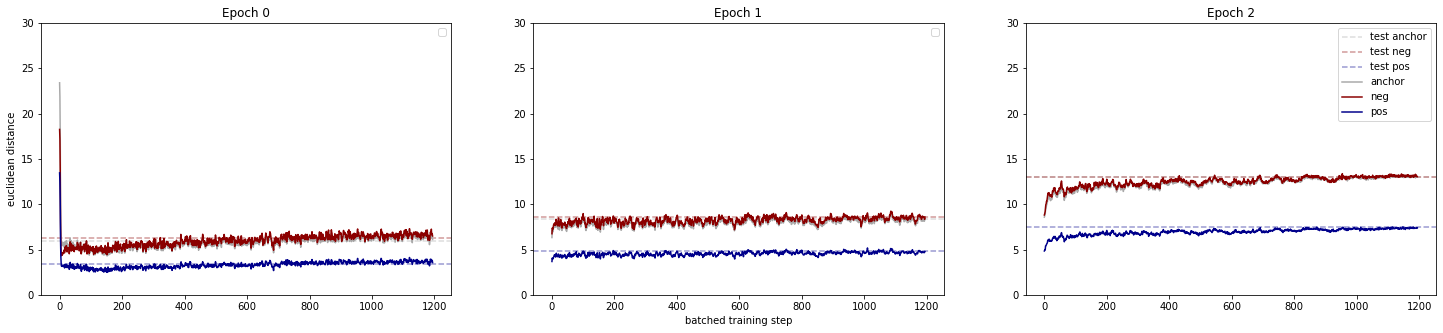

In [113]:
f, ax = plt.subplots(ncols=3, figsize=(25,5))
for i in range(3):
    n_d = _roll_avg(d[f'epoch-{str(i)}']['dist_neg'])
    p_d = _roll_avg(d[f'epoch-{str(i)}']['dist_pos'])
    a_d = _roll_avg(d[f'epoch-{str(i)}']['dist_anchor'])
    test_n_d = np.mean(d[f'epoch-{str(i)}']['test_dist_neg'])
    test_p_d = np.mean(d[f'epoch-{str(i)}']['test_dist_pos'])
    test_a_d = np.mean(d[f'epoch-{str(i)}']['test_dist_anchor'])
    ax[i].set_ylim(0,30)
    ax[i].axhline(test_a_d, ls='--', 
                  color='darkgrey', 
                  alpha=.4, label='test anchor')
    ax[i].axhline(test_n_d, ls='--', 
                  color='darkred', 
                  alpha=.4, label='test neg')
    ax[i].axhline(test_p_d, ls='--', 
                  color='darkblue', 
                  alpha=.4, label='test pos')
    ax[i].set_title(f'Epoch {i}')
    if i == 1:
        ax[i].set_xlabel('batched training step')
    if i == 0:
        ax[i].set_ylabel('euclidean distance')
    sns.lineplot(x=range(len(a_d)), y=a_d, ax=ax[i], label='anchor', color='darkgrey')
    sns.lineplot(x=range(len(n_d)), y=n_d, ax=ax[i], label='neg', color='darkred')
    sns.lineplot(x=range(len(p_d)), y=p_d, ax=ax[i], label='pos', color='darkblue')
    if i != 2:
        ax[i].legend('')
    else:
        ax[i].legend(loc='upper right')
plt.show()

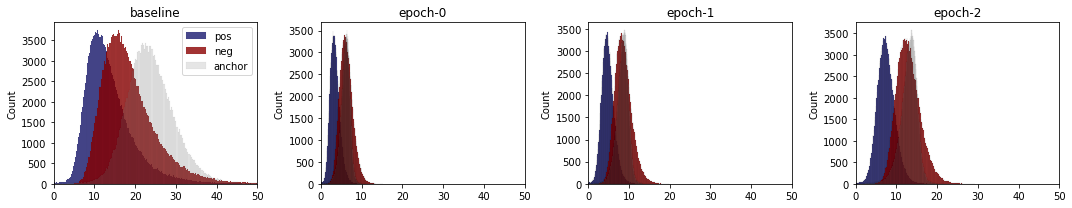

In [114]:
# test distributions
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,3))
for idx, k in enumerate(['baseline', 'epoch-0', 'epoch-1', 'epoch-2']):
    sns.histplot(x=d[k]['test_dist_pos'], color='midnightblue', alpha=.8, ax=ax[idx], label='pos')
    sns.histplot(x=d[k]['test_dist_neg'], color='darkred', alpha=.8, ax=ax[idx], label='neg')
    sns.histplot(x=d[k]['test_dist_anchor'], color='grey', alpha=.2, ax=ax[idx], label='anchor')
    ax[idx].set_xlim(0,50)
    ax[idx].set_title(k)
    if idx == 0:
        ax[idx].legend()
plt.tight_layout()
plt.show()

### Visualize relation with text features

#### Performance ~ nr anchor posts

In [115]:
JSON_PATH = Path('../reddit/data/json/triplet/1pos_1neg_random/')
json_files = glob.glob(str(JSON_PATH / '*'))
test_ids = d['epoch-0']['test_example_ids'] + \
           d['epoch-1']['test_example_ids'] + \
           d['epoch-2']['test_example_ids']
ad = {}
skip_files = []
for idx, f in enumerate(json_files): # load each file
    batch = json.load(gzip.open(f))
    batch = [{'author_id': int(b['author_id']), # just keep relevant fields
              'n_posts': np.min([len(b['anchor']), 10]),
              'pos_subreddit_overlap': b['pos_subreddit_overlap'],
              'neg_subreddit_overlap': b['neg_subreddit_overlap']} for b in batch]
    batch_df = pd.DataFrame(batch)
    subs_df = batch_df[batch_df['author_id'].isin(test_ids)] # only keep the test examples
    if subs_df.shape[0] == 0:
        skip_files.append(f.split('/')[-1].strip('.json.gz')) # log if there's no example in this batch
    else:
        ad.update(subs_df.set_index('author_id').to_dict('index')) # else add to author dictionary

In [116]:
tf_files = glob.glob('../reddit/data/datasets/triplet/1pos_1neg_random/*')
tf_files = [t for t in tf_files if not t.split('/')[-1].split('-')[0] in skip_files]

In [117]:
tf_ds = load_tfrecord(tf_files)

In [118]:
for e in tf_ds:
    if e['author_id'].numpy() in ad.keys():
        nz = np.mean(tf.math.count_nonzero(e['iids'][:10,:], axis=1))
        ad[e['author_id'].numpy()]['mean_token_length'] = nz 

In [119]:
# See how a post is classified
for e_idx in range(len(d[f'epoch-0']['test_metrics'])):
    a_id = d[f'epoch-0']['test_example_ids'][e_idx]
    if a_id in ad.keys():
        for i in range(3):
            ad[a_id][f'metric_{str(i)}'] = d[f'epoch-{str(i)}']['test_metrics'][e_idx]
        ad[a_id][f'metric_baseline'] = d[f'baseline']['test_metrics'][e_idx]

In [120]:
adf = pd.DataFrame(ad).T.reset_index()

In [121]:
n_posts = adf[['n_posts', 
               'metric_baseline',
               'metric_0', 
               'metric_1', 
               'metric_2'
               ]].groupby('n_posts').agg('mean').reset_index()

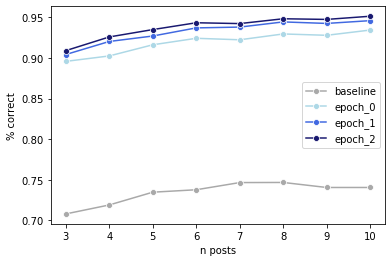

In [122]:
sns.lineplot(data=n_posts, x='n_posts', y='metric_baseline', color='darkgrey', label='baseline', linestyle='-', marker='o')
sns.lineplot(data=n_posts, x='n_posts', y='metric_0', color='lightblue', label='epoch_0', linestyle='-', marker='o')
sns.lineplot(data=n_posts, x='n_posts', y='metric_1', color='royalblue', label='epoch_1', linestyle='-', marker='o')
sns.lineplot(data=n_posts, x='n_posts', y='metric_2', color='midnightblue', label='epoch_2', linestyle='-', marker='o')
plt.legend()
plt.xlabel('n posts')
plt.ylabel('% correct')
plt.show()

#### Performance ~ same/difference subreddit

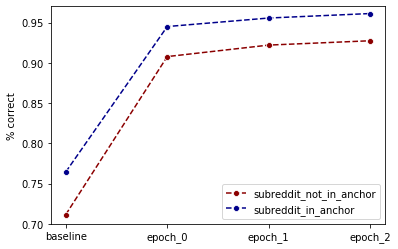

In [123]:
overlap = adf.groupby('pos_subreddit_overlap')[['metric_baseline',
                                                'metric_0', 
                                                'metric_1', 
                                                'metric_2'
                                               ]].mean().reset_index()
metrics_0 = overlap[['metric_baseline', 'metric_0', 'metric_1', 'metric_2']].iloc[0]
metrics_1 = overlap[['metric_baseline', 'metric_0', 'metric_1',  'metric_2']].iloc[1]
sns.lineplot(x=['baseline', 'epoch_0', 'epoch_1', 'epoch_2'], y=metrics_0, color='darkred', label='subreddit_not_in_anchor', linestyle='--', marker='o')
sns.lineplot(x=['baseline', 'epoch_0', 'epoch_1', 'epoch_2'], y=metrics_1, color='darkblue', label='subreddit_in_anchor', linestyle='--', marker='o')
plt.ylim(0.7,.97)
plt.ylabel('% correct')
plt.legend()
plt.show()

#### Performance ~ avg length (in tokens)

In [124]:
ints = np.arange(0,540,5)
labels = [i for i in ints[1:]]
adf['token_bins'] = pd.cut(adf['mean_token_length'], 
                           bins=ints,
                           labels=labels)

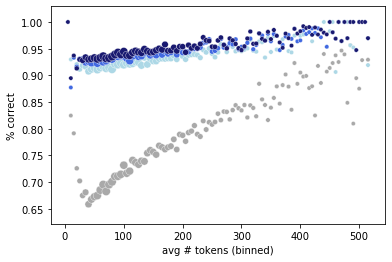

In [125]:
token_bins = adf.groupby('token_bins')[['metric_baseline',
                                        'metric_0', 
                                        'metric_1', 
                                        'metric_2'
                                       ]].agg(['mean', 'count']).reset_index()
token_bins.columns = ['token_bins', 
                      'metric_baseline', 'metric_baseline_count',
                      'metric_0', 'metric_0_count',
                      'metric_1', 'metric_1_count', 
                      'metric_2', 'metric_2_count'
                     ]
sns.scatterplot(data=token_bins, x='token_bins', y='metric_baseline', size='metric_baseline_count', legend=False, color='darkgrey')
sns.scatterplot(data=token_bins, x='token_bins', y='metric_0', size='metric_0_count', legend=False, color='lightblue')
sns.scatterplot(data=token_bins, x='token_bins', y='metric_1', size='metric_1_count', legend=False, color='royalblue')
sns.scatterplot(data=token_bins, x='token_bins', y='metric_2', size='metric_2_count', legend=False, color='midnightblue')
plt.xlabel('avg # tokens (binned)')
plt.ylabel('% correct')
plt.show()

### Visualize some examples

In [126]:
unlearned_ids = [k for k,v in ad.items() if (v['metric_baseline'] == 1.0) & \
                                            ((v['metric_0'] == 0.0) | \
                                             (v['metric_1'] == 0.0))]
learned_ids = [k for k,v in ad.items() if (v['metric_baseline'] == 0.0) & \
                                         ((v['metric_0'] == 1.0) | \
                                          (v['metric_1'] == 1.0))]
not_learned_ids = [k for k,v in ad.items() if (v['metric_baseline'] == 0.0) & \
                                              (v['metric_0'] == 0.0) & \
                                              (v['metric_1'] == 0.0)]

In [127]:
unlearned_dict = {}
learned_dict = {}
not_learned_dict = {}

for idx, f in enumerate(json_files):
    batch = json.load(gzip.open(f))
    batch_df = pd.DataFrame(batch)
    unlnd = batch_df[batch_df['author_id'].isin(unlearned_ids)].set_index('author_id').to_dict('index')
    lnd = batch_df[batch_df['author_id'].isin(learned_ids)].set_index('author_id').to_dict('index')
    not_lnd = batch_df[batch_df['author_id'].isin(not_learned_ids)].set_index('author_id').to_dict('index')
    unlearned_dict.update(unlnd)
    learned_dict.update(lnd)
    not_learned_dict.update(not_lnd)

In [128]:
def _sample_from_dict(d, n):
    sample_ids = random.sample(list(d.keys()), n)
    sampled = [{'anchor':v['anchor'], 
                'positive': v['positive'],
                'negative': v['negative']} for k,v in d.items() if k in sample_ids]
    return sampled

In [129]:
def printmd(string):
    display(Markdown(string))

In [130]:
def _print_examples(sampled):
    for s in sampled:
        printmd('<br><span style="color:grey">**Anchor**</span>')
        for a in s['anchor'][:3]:
            astr = ' '.join(a.split()[:150])
            printmd(f'&nbsp;&nbsp;&nbsp;<span style="color:grey">{astr}</span>')
        printmd('<br><span style="color:#2E86C1">**Positive**</span>')
        pstr = ' '.join(s['positive'][0].split()[:150])
        printmd(f'&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:#2E86C1">{pstr}</span>')
        printmd('<br><span style="color:#C0392B">**Negative**</span>')
        nstr = ' '.join(s['negative'][0].split()[:150])
        printmd(f'&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:#C0392B">{nstr}</span>')

### Sample "unlearned" examples

In [131]:
_print_examples(_sample_from_dict(unlearned_dict, 1))

<br><span style="color:grey">**Anchor**</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">Im really wanting old world rustic style foods, ya know, more natural meals to kinda help with weight loss and since I follow CICO this would work great. Anything form Europe / Scandanavian / Russian styles?</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">I like most work a lot, on average I am putting in 100 to 130 hours at work every check because min-wage is like that to make any kind of money beyond bills. I just want to come home and be able to pick up and play for the 1 hour I get to but no, I have to spend that 1 hour or less doing a glitch to unlock characters, among other things stopping me from playing... I have played 1 online match since I got the game... since the game has come out I have been unlocking characters... This was not a well thought out mechanic...</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">I want to return to WoW and everytime I do, it takes months to re-orient my self to the same bs. It is over packed with crap and to me its losing what I loved about the game so much. Are there any MMo's out there that are not pay to win that have a large enough player base that offer what will bring back that fun gaming experience that WoW gave me?</span>

<br><span style="color:#2E86C1">**Positive**</span>

&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:#2E86C1">So I looked at my subscribed items and it says cc: 1.76 Journey says last updated Jun 27th 2018. Now I was looking at the Megamod 0.0.6 is there a newer version of that one? since it has CC and other mods?</span>

<br><span style="color:#C0392B">**Negative**</span>

&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:#C0392B">Hot Male</span>

### Sample learned examples

In [132]:
_print_examples(_sample_from_dict(learned_dict, 1))

<br><span style="color:grey">**Anchor**</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">Maybe I'm looking for a different perspective, but certain things about the profession seem very bleak to me as I'm getting closer to the completion of my degree. It's a math degree, so there are other options out there that don't require me to go to grad school. First off, I'm a pretty good reader of body language. Forget about the several people I know who have actually left the profession. People I've met in the field whose body language screams burnt out. But it's not just anecdotal. The numbers support this. Poor working conditions, overbearing administrative BS, loss of disciplinary control, lack of cooperation and support from parents, and pay that hardly justifies any of it. You may ask, what is it that gave me that passion in the first place? Well, I used to be a tutor. I loved it, especially when I helped the kids with math.</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">Anyone else having a tough time with this one? It seems like the game is stuck on 1 of 2 when I've already baited and killed numerous herbivores and predators. Does the black bear not count?</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">First playthrough, I went for the big sappy ending and fist fight with Micah, climactic final breath on the side of the cliff. One thing that didn't make sense, why didn't Micah kill me? So Dutch walks away from it all, and Micah has the perfect window for a cheap kill, and just decides not to? Now it's a similar end in the other route, but this time it was a knife fight that was much more in favor of Arthur (maybe I'm just better with a knife). But even in the cut scene, Arthur straight up takes out his eye. It's more believable that without a gun, Micah decides to cut his losses. Let's face it, once Arthur served his purpose it only makes sense that he really goes out fighting.</span>

<br><span style="color:#2E86C1">**Positive**</span>

&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:#2E86C1">Frankly, it verges on science denial. That zucchini pasta might look and even taste like pasta. But it's not going to deliver that fix for refined carbs. It's not going to make it any easier, because you didn't eat those heaps of carbs simply for the taste. You were satisfied by the fix. So that which tastes just like it doesn't cut it. To me it just seems like people are tricking themselves into thinking if they can just emulate the taste, then a low carb diet will be easy. But by design, it's not meant to be easy if you were once hooked on the stuff. You have to find healthier ways to satisfy yourself and hopefully serve as a distraction. Work out, have sex (or jerk off if you must), clean your house, etc.</span>

<br><span style="color:#C0392B">**Negative**</span>

&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:#C0392B">I might believe that this is common sense, but as many of my friends just didnt get it, here's a quick guide on how to surrender properly if you just dont want to get tilted any further just like i usually do. There's no problem in starting a Surrendervote post-20, but the timeframe inbetween minute 15 and minute 20 has its own rules. Sometimes theres just that one 5/5/0 Yasuo in your 5-30 game who still believes there is a chance and he's our Antagonist today. If you already want to early surrender; the best time to do it first is in between the window of 15 and 16 minutes. This allows A) a free surrender vote and B) a new vote to be casted after 19 minutes. I'll explain later why thats important. Also, you'll get quick information on what your team thinks about surrender, having a 4-1 is</span>

### Sample not learned stuff

In [133]:
_print_examples(_sample_from_dict(not_learned_dict, 1))

<br><span style="color:grey">**Anchor**</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">SMUGGLER Dark side, Smuggler, Attacker Prepared (basic): Deal physical damage to target enemy. If Smuggler is prepared, he recovers +5% max health and gains +2% protection at the start of each enemy turn and loses prepared. If Smuggler is not prepared, he calls all unprepared allies to assist and grants them prepared for 3 turns, if any smuggler allies are prepared, Smuggler loses 100% turn meter, gains +20% turn meter and reduces all enemies turn meter by -5% unless 2 or more Smuggler allies are prepared, or unprepared, or has been prepared in the past 3 turns. If Smuggler has been damaged or not damaged he may or may not gain prepared until the next time he is not prepared, only if Smuggler has been prepared 2 or more times this encounter. If that is so, and this process occurs more than once before an enemy that a prepared smuggler</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">Spoiler alert: it still is very long, even when simplified. But the ultra simplified version is: Revan lead boosts Jedi and Old Republic allies damage output and grants them 4 different things: Tenacity up for 1 turn at the start of each encounter And strategic advantage, which is 3 different things: Retribution, but in debuff form It's also a buff And an ability --- Explained little bit longer way: Jedi and Old Republic hit harder, gain tenacity up at the start of each encounter and when they damage an enemy with protection up, that enemy loses -10% of their max health pool (stacking). Jedi allies also gain a new ability/buff hybrid similar to Thrawn lead. They gain the ability to have the buff and use the ability, which are one in the same if no other ally has this hybrid buff/ability thing which is called Strategic advantage What Strategic advantage</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">Darth Maul is obviously making a comeback, and it got me thinking that it's pretty suprising that he can still be used to take 1st even though he released years ago. What other characters are old, but good?</span>

<br><span style="color:#2E86C1">**Positive**</span>

&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:#2E86C1">If i get stressed out or have anixety, the next time i get a minute i use my phone. I feel myself calming down too. I feel like this is a bad thing but i wanna know if i'm the only one.</span>

<br><span style="color:#C0392B">**Negative**</span>

&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:#C0392B">VALVe, what happened to it? * Competitive balance is Dota's crown jewel, and to ensure everyone is playing on an even field, the core content of the game—like the vast pool of heroes—is available to all players. Fans can collect cosmetics for heroes and fun add-ons for the world they inhabit, but everything you need to play is already included before you join your first match. ...totally free to play in the way we wish all free-to-play games could be -IGN * What happened to the crown jewel of Dota that ensures everyone is playing on an even field?</span>

## By-word attention changes

In [134]:
# This should probably be run on GPU

In [135]:
from reddit import BatchTransformer
from transformers import TFDistilBertModel, DistilBertTokenizer

In [136]:
pretrained_model = BatchTransformer(TFDistilBertModel, 'distilbert-base-uncased', 
                                    output_attentions=True)
trained_model = BatchTransformer(TFDistilBertModel, 'distilbert-base-uncased', 
                                 output_attentions=True)
tknzr = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-base-uncased were no

In [137]:
%%capture
ckpt_file = tf.train.latest_checkpoint('../logs/10anchor_1pos_1neg_random/'
                                       'checkpoint/BatchTransformer-distilbert-base-uncased/'
                                       'triplet_loss_margin-1.0/epoch-2')
trained_model.load_weights(ckpt_file)

In [148]:
examples = _sample_from_dict(learned_dict, 1000)

In [ ]:
%%capture
wds, vals, ns, models, exs = [], [], [], [], []
for m in zip(['trained', 'pretrained'],
             [trained_model, pretrained_model]):
    for e_idx, e in enumerate(examples):
        encoded = tknzr.encode_plus(e['positive'][0], 
                                    return_tensors='tf', 
                                    truncation=True)
        decoded = []
        for e in encoded['input_ids'][0]:
            decoded.append(tknzr.decode(e))
        encoded = {'input_ids': tf.expand_dims(encoded['input_ids'], axis=0), 
                   'attention_mask': tf.expand_dims(encoded['attention_mask'], axis=0)}
        _, atts = m[1](encoded)
        for n in range(6):
            out = list(tf.reduce_mean(tf.squeeze(atts[n][0][:,0,:]), axis=0).numpy())
            wds += decoded
            vals += out
            ns += [n] * len(out)
            models += [m[0]] * len(out)
            exs += [e_idx] * len(out)

In [254]:
att_df = pd.DataFrame(zip(wds, vals, ns, models, exs), 
                      columns=['token', 'value', 
                               'layer', 'model', 
                               'example'])
att_df.to_csv('attentions_10anchor_1pos_1neg_random/attention_1000examples.tsv', 
              sep='\t')

In [250]:
tt = att_df[att_df['model']=='trained']
pt = att_df[att_df['model']=='pretrained']
tt = tt.drop('model', axis=1).merge(pt.drop('model', axis=1), 
                                    on=['token', 'layer', 'example'])
tt['diff'] = tt['value_x'] - tt['value_y']
tt = tt.groupby(['token']).diff.agg([np.mean, 
                                     np.std])\
                               .reset_index()

In [251]:
tt.sort_values(by='mean').head(n=30).token.apply(lambda x: x.replace(' ', '')).tolist()

['bunny',
 'worlds',
 'revived',
 '##resh',
 'indirect',
 'outstanding',
 'profile',
 'muscles',
 'bald',
 'canceled',
 'camping',
 'balloon',
 'spikes',
 'farther',
 'skipped',
 '##aa',
 'framework',
 'buyer',
 'riddle',
 'climb',
 'booster',
 'tags',
 'eastern',
 'spinning',
 'enhance',
 'strain',
 'fares',
 'matches',
 'monk',
 'survival']

In [252]:
tt.sort_values(by='mean').tail(n=30).token.apply(lambda x: x.replace(' ', '')).tolist()

['##fold',
 'vietnamese',
 'iso',
 'whiskey',
 'chinatown',
 'babies',
 'kramer',
 'swam',
 'poked',
 'discouraged',
 'mate',
 'ow',
 'propeller',
 'nut',
 'grimm',
 'kenyan',
 'unlawful',
 'ted',
 'tibet',
 'cesar',
 'starbucks',
 'pumped',
 'nes',
 'oilers',
 '##mps',
 'regiment',
 'hebrew',
 'nyc',
 '##ange',
 'warehouse']

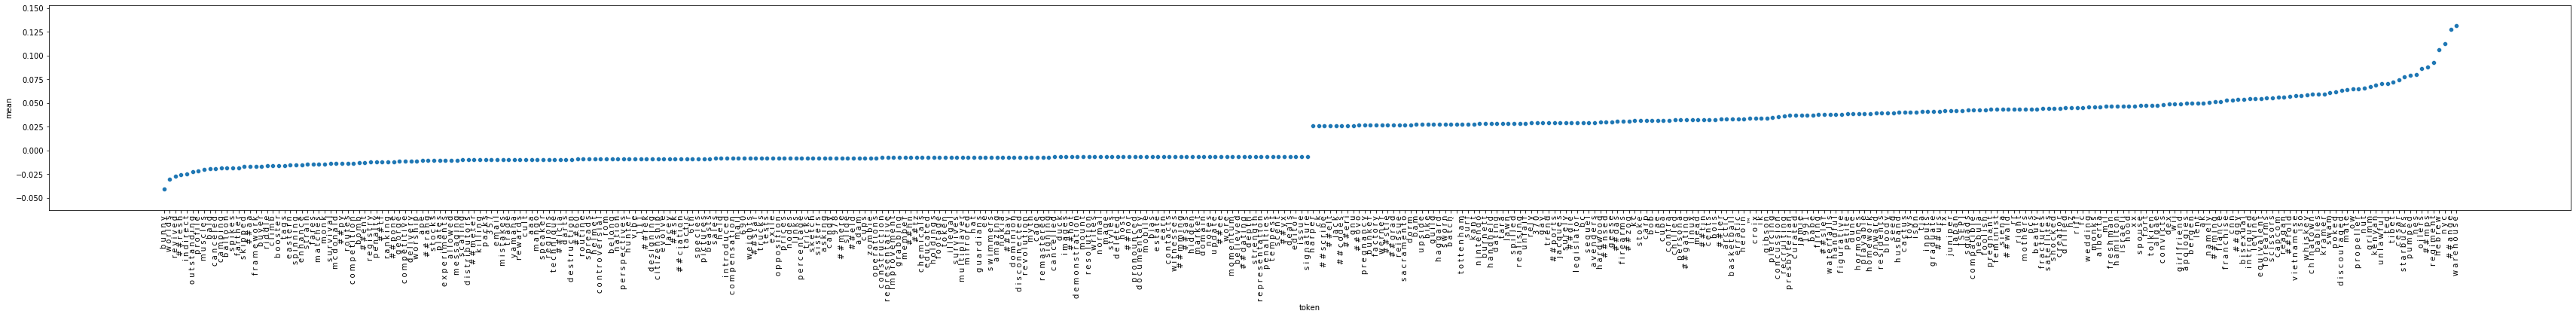

In [253]:
f, ax = plt.subplots(figsize=(60,5))
sns.scatterplot(data=tt.sort_values(by='mean').iloc[list(range(200)) + \
                                                    list(range(-200,0)),:], 
                x='token', y='mean')
plt.xticks(rotation=90)
plt.show()

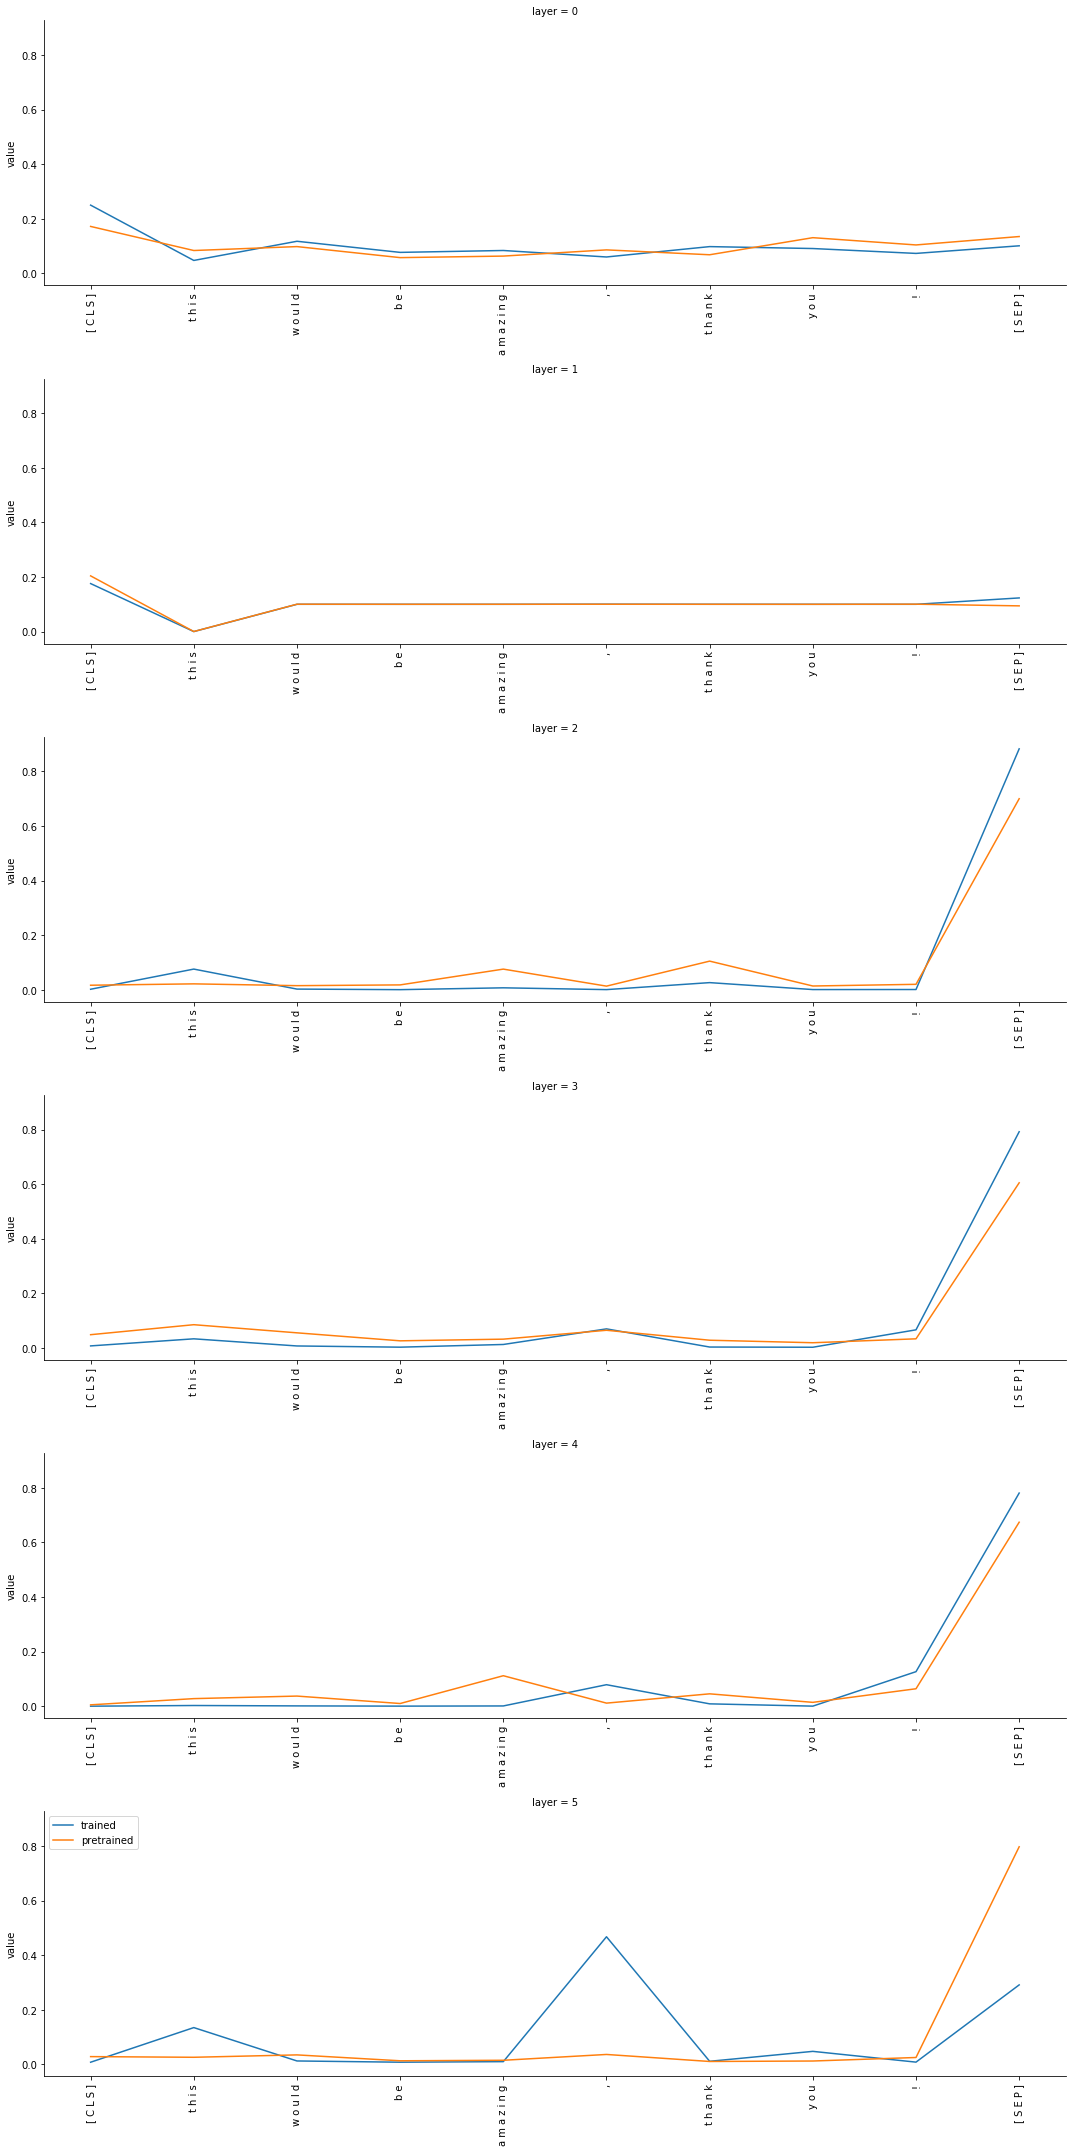

In [257]:
fg = sns.FacetGrid(data=att_df[att_df['example']==61],
                   row='layer', sharex=False, hue='model', 
                   height=5, aspect=3)
fg.map(sns.lineplot, 'token', 'value')
for ax in fg.axes.flat:
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# NEXT
# Find out what is going on
# Add embedding visualize and scoring of sentences, authors, subreddit before and after training